In [18]:
from imutils import paths
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import timeit

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.xception import decode_predictions

In [2]:
print("[INFO]: Trying to Read the images")
#  Configure the Image Location
# 이미지 위치 구성하기
imagePaths = list(paths.list_images(r'C:\Users\cvpr\Documents\Bishal\Allergic Rhinitis\Dataset\non_rotate'))

[INFO]: Trying to Read the images


In [3]:
imagePaths = list(paths.list_images("Dataset/rotate"))
len(imagePaths)
imagePaths[0].split(os.path.sep)[-3]

'dataset0'

In [4]:
len(imagePaths)

90

In [5]:
from datetime import datetime
datetime.now().strftime('%H:%M:%S')

'12:44:43'

In [6]:
# Initialize data and labels
# 데이터 및 레이블 초기화
data = []
labels = []
dirList= []

In [7]:
# Formatting data and labels
for imagePath in imagePaths:
    # Extract the class label from file name and append to labels
    # 파일 이름에서 클래스 레이블을 추출하고 레이블에 추가함
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    # Load the image, swap color channels, and resize it to be a fixed 224x224 pixels while ignoring the aspect ratio
    # 이미지를 로드하고, 컬러 채널을 스왑하고, 가로 세로 비율을 무시하고 고정 224x224 픽셀로 크기를 조정함
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    # Append to data
    # 데이터에 추가
    data.append(image)

# Convert the data and labels to NumPy arrays while scaling the pixel intensities to the range [0,1]
# 픽셀 강도를 [0,1] 범위로 조정하면서 데이터와 레이블을 NumPy 배열로 변환
data = np.array(data) / 255.0
labels = np.array(labels)

In [8]:
labels.shape

(90,)

In [9]:
labels

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '2',
       '2', '2', '2', '2', '2', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '2', '2', '2',
       '2', '2', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1',
       '1', '1', '2', '2', '2', '2', '2', '2', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '1', '1', '2', '2', '2', '2', '2', '2'],
      dtype='<U1')

In [10]:
data.shape

(90, 224, 224, 3)

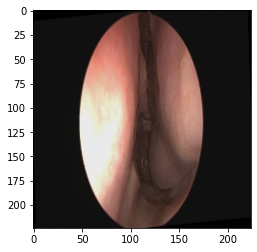

In [11]:
plt.imshow(data[1])

In [12]:
# Perform the one-hot encoding on the labels
# 레이블에 대해 원핫 인코딩 수행
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [13]:
# Initialize the training data augmentation
# 교육 데이터 억멘테이션 초기화
trainAug = ImageDataGenerator(rotation_range=40, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2,
		shear_range=0.15,fill_mode="nearest", horizontal_flip=True)

In [14]:
labels.shape

(90, 3)

In [15]:
# Partition the data into training and testing splits using 80% of the training data and the remaining 20% for testing
# 교육 데이터의 80%, 테스트에 20%를 사용하여 데이터를 교육 및 테스트 분할로 분할
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [19]:
# Load the network, ensuring the Head-FC layer sets are left off
# Head-FC 레이어 세트가 포함되지 않도록 네트워크를 로드한다
baseModel = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

In [20]:
# Construct the head model that will be placed on the top of the base model
# 보디 모델의 맨 위에 배치할 헤드 모델 구성
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4,4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [21]:
# Place the Head-FC model on top of the Base model - This become the actual model that we will train
# Head-FC 모델을 보디 모델 위에 배치한다. 이것이 우리가 교육할 실제 모델이 될 것이다.
model = Model(inputs=baseModel.input, outputs=headModel)

In [22]:
# Make sure that the basemodel layers will not be trained and only head model will be trained.
# 보디 모델 레이어가 훈련되지 않고 헤드 모델만 훈련되는지 확인한다.
for layer in baseModel.layers:
    layer.trainable = False

In [23]:
trainX.shape

(72, 224, 224, 3)

In [24]:
testX.shape

(18, 224, 224, 3)

In [27]:
# Set the hyper-parameters
# 하이퍼 파라미터 설정
# INIT_LR = 1e-3
INIT_LR = 0.001
EPOCHS = 100
BS = 8

In [28]:
# Compile the Model
# 모델 컴파일
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [29]:
# Train the Network Model
# 모델 교육
print("[INFO] Model Training")
start = timeit.default_timer()
H = model.fit(
        trainAug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
        epochs=EPOCHS)

[INFO] Model Training
Epoch 1/100
9/9 [==============================] - 10s 406ms/step - loss: 0.6775 - accuracy: 0.4722 - val_loss: 0.5493 - val_accuracy: 0.5000
Epoch 2/100
9/9 [==============================] - 1s 101ms/step - loss: 0.6149 - accuracy: 0.5556 - val_loss: 0.5440 - val_accuracy: 0.5000
Epoch 3/100
9/9 [==============================] - 1s 97ms/step - loss: 0.5773 - accuracy: 0.5972 - val_loss: 0.5598 - val_accuracy: 0.4444
Epoch 4/100
9/9 [==============================] - 1s 96ms/step - loss: 0.5732 - accuracy: 0.5972 - val_loss: 0.4996 - val_accuracy: 0.7222
Epoch 5/100
9/9 [==============================] - 1s 94ms/step - loss: 0.5668 - accuracy: 0.5694 - val_loss: 0.5202 - val_accuracy: 0.6111
Epoch 6/100
9/9 [==============================] - 1s 98ms/step - loss: 0.6224 - accuracy: 0.5139 - val_loss: 0.4901 - val_accuracy: 0.7222
Epoch 7/100
9/9 [==============================] - 1s 96ms/step - loss: 0.6051 - accuracy: 0.6389 - val_loss: 0.4998 - val_accuracy: 0.

Epoch 59/100
9/9 [==============================] - 1s 101ms/step - loss: 0.3800 - accuracy: 0.7500 - val_loss: 0.5547 - val_accuracy: 0.6111
Epoch 60/100
9/9 [==============================] - 1s 101ms/step - loss: 0.4108 - accuracy: 0.7917 - val_loss: 0.5927 - val_accuracy: 0.6667
Epoch 61/100
9/9 [==============================] - 1s 106ms/step - loss: 0.3368 - accuracy: 0.7500 - val_loss: 0.5408 - val_accuracy: 0.7222
Epoch 62/100
9/9 [==============================] - 1s 102ms/step - loss: 0.3486 - accuracy: 0.7917 - val_loss: 0.5834 - val_accuracy: 0.7222
Epoch 63/100
9/9 [==============================] - 1s 101ms/step - loss: 0.2961 - accuracy: 0.8056 - val_loss: 0.5817 - val_accuracy: 0.6667
Epoch 64/100
9/9 [==============================] - 1s 99ms/step - loss: 0.2819 - accuracy: 0.8472 - val_loss: 0.6223 - val_accuracy: 0.7222
Epoch 65/100
9/9 [==============================] - 1s 101ms/step - loss: 0.3299 - accuracy: 0.7778 - val_loss: 0.6269 - val_accuracy: 0.6667
Epoch 6

In [30]:
stop = timeit.default_timer()
print('Total Training Time: ', stop - start) 

Total Training Time:  104.03932329999998


In [31]:
testX.shape

(18, 224, 224, 3)

In [32]:
# Make predictions on the testing set
# 테스트 세트에서 예측한다
print("Making Predictions on the Test Set")
predIdxs = model.predict(testX, batch_size=BS)
preds = predIdxs
predIdxs = np.argmax(predIdxs, axis=1)
print("Classification Report")
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

Making Predictions on the Test Set
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.89      0.73         9
           1       0.50      0.33      0.40         3
           2       0.67      0.33      0.44         6

    accuracy                           0.61        18
   macro avg       0.59      0.52      0.52        18
weighted avg       0.61      0.61      0.58        18



In [33]:
preds

array([[9.88432586e-01, 2.65772827e-03, 8.90968181e-03],
       [1.31525666e-01, 3.03464402e-02, 8.38127851e-01],
       [2.69699246e-02, 2.79573761e-02, 9.45072711e-01],
       [9.15169060e-01, 2.56400369e-02, 5.91909885e-02],
       [1.04994401e-01, 8.70037258e-01, 2.49682870e-02],
       [9.99693751e-01, 1.52837703e-04, 1.53506728e-04],
       [9.01472688e-01, 4.02760804e-02, 5.82512319e-02],
       [8.82848561e-01, 1.12393916e-01, 4.75757150e-03],
       [9.96787429e-01, 1.24251688e-04, 3.08826845e-03],
       [9.99790013e-01, 8.60633645e-06, 2.01369199e-04],
       [9.12856698e-01, 8.43511969e-02, 2.79211695e-03],
       [9.81156111e-01, 2.78115133e-03, 1.60627924e-02],
       [9.99953270e-01, 1.00948255e-05, 3.66526583e-05],
       [8.49873662e-01, 5.76223596e-04, 1.49550155e-01],
       [9.56065953e-02, 6.52263343e-01, 2.52130091e-01],
       [8.56915295e-01, 1.52818132e-02, 1.27802864e-01],
       [3.32001120e-01, 2.90964037e-01, 3.77034843e-01],
       [9.95243251e-01, 2.17276

In [34]:
len(predIdxs)

18

In [35]:
# Compute Confusion Matrix and derrive raw, accuracy, sensitivity, specificity from it
# 혼란 매트릭스
cm= confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0,0] + cm[1,1] + cm[2,2]) / total

sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
# 혼란 매트릭스 보기
print("Confusion Matrix and its Derrivatives")
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

Confusion Matrix and its Derrivatives
[[8 0 1]
 [2 1 0]
 [3 1 2]]
acc: 0.6111
sensitivity: 1.0000
specificity: 0.3333


In [36]:
H.history["accuracy"]

[0.4722222089767456,
 0.5555555820465088,
 0.5972222089767456,
 0.5972222089767456,
 0.5694444179534912,
 0.5138888955116272,
 0.6388888955116272,
 0.5555555820465088,
 0.7083333134651184,
 0.6666666865348816,
 0.6666666865348816,
 0.6666666865348816,
 0.5833333134651184,
 0.6388888955116272,
 0.6111111044883728,
 0.6388888955116272,
 0.6805555820465088,
 0.6388888955116272,
 0.6944444179534912,
 0.6111111044883728,
 0.6388888955116272,
 0.6388888955116272,
 0.7777777910232544,
 0.7361111044883728,
 0.6527777910232544,
 0.6388888955116272,
 0.7777777910232544,
 0.6805555820465088,
 0.5972222089767456,
 0.6944444179534912,
 0.7083333134651184,
 0.75,
 0.7777777910232544,
 0.7638888955116272,
 0.6805555820465088,
 0.6666666865348816,
 0.7916666865348816,
 0.75,
 0.6805555820465088,
 0.7638888955116272,
 0.7222222089767456,
 0.7638888955116272,
 0.7361111044883728,
 0.6805555820465088,
 0.7361111044883728,
 0.6944444179534912,
 0.7222222089767456,
 0.6944444179534912,
 0.75,
 0.75,
 0.75,

Final Plot Generated.


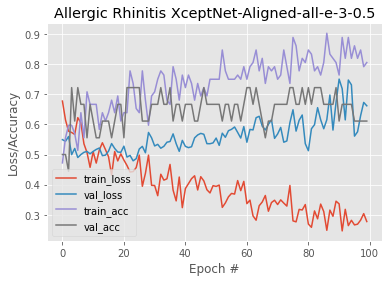

In [37]:
# plot the training loss and accuracy
# 플롯 그래프
print("Final Plot Generated.")
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Allergic Rhinitis XceptNet-Aligned-all-e-3-0.5")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("[iter-3] [XCEPTN] plot,rotate-1e3")

model.output_shape # model summary representation
model.summary() # model configuration
model.get_config() # list all weight tensors in the model

In [38]:
model.output_shape

(None, 3)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [40]:
preds

array([[9.88432586e-01, 2.65772827e-03, 8.90968181e-03],
       [1.31525666e-01, 3.03464402e-02, 8.38127851e-01],
       [2.69699246e-02, 2.79573761e-02, 9.45072711e-01],
       [9.15169060e-01, 2.56400369e-02, 5.91909885e-02],
       [1.04994401e-01, 8.70037258e-01, 2.49682870e-02],
       [9.99693751e-01, 1.52837703e-04, 1.53506728e-04],
       [9.01472688e-01, 4.02760804e-02, 5.82512319e-02],
       [8.82848561e-01, 1.12393916e-01, 4.75757150e-03],
       [9.96787429e-01, 1.24251688e-04, 3.08826845e-03],
       [9.99790013e-01, 8.60633645e-06, 2.01369199e-04],
       [9.12856698e-01, 8.43511969e-02, 2.79211695e-03],
       [9.81156111e-01, 2.78115133e-03, 1.60627924e-02],
       [9.99953270e-01, 1.00948255e-05, 3.66526583e-05],
       [8.49873662e-01, 5.76223596e-04, 1.49550155e-01],
       [9.56065953e-02, 6.52263343e-01, 2.52130091e-01],
       [8.56915295e-01, 1.52818132e-02, 1.27802864e-01],
       [3.32001120e-01, 2.90964037e-01, 3.77034843e-01],
       [9.95243251e-01, 2.17276

In [35]:
model.save("ARhinitisModel", save_format="h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

C:\Users\cvpr\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


print("[INFO] saving Allergic Rhinitis detector model...")
model.save("ARhinitisModel", save_format="h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

decoded = imagenet_utils.decode_predictions(preds)

gradCAM


In [41]:
from gradCam import GradCAM
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [42]:
d_path = r'C:\Users\cvpr\Documents\Bishal\Allergic Rhinitis\Dataset\non_rotate\dataset0\1\7_1_00005_left.tif'
orig = cv2.imread(d_path)
resized = cv2.resize(orig, (224, 224))
image = load_img(d_path, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

cam = GradCAM(model, predIdxs)

In [43]:
preds = model.predict(image)
i = np.argmax(preds[0])
print(image.shape)

(1, 224, 224, 3)


In [44]:
cam = GradCAM(model, i)

In [45]:
heatmap = cam.compute_heatmap(image)

In [46]:
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))

In [47]:
cv2.imshow("Output", heatmap)
cv2.imwrite("heatr", heatmap)

error: OpenCV(4.5.1) ..\modules\imgcodecs\src\loadsave.cpp:682: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'


In [ ]:

(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

In [ ]:
for i in testX:
    image = np.expand_dims(i, axis=0)
    image = imagenet_utils.preprocess_input(i)
    heatmap = cam.compute_heatmap(image)